# **Este *ipynb* está enmarcado dentro de un trabajo que busca predecir qué alumnos del departamento de Sistemas la UTN FRBA desertarán.**

Los datos disponibles fueron unificados en una sola tabla y se removieron los registros con valores nulos.

Se utilizarán herramientas del aprendizaje estadístico para crear un modelo supervisado que prediga el outcome de la variable 'deserto'.

## **Importación de librerías**

In [129]:
## Importamos librerías para manipulación de datos.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [130]:
## Importamos librerías de aprendizaje automático.
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [131]:
# Importamos librerías para poder crear Pipelines.
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [132]:
# Importamos librerias de PCA.
from sklearn.decomposition import PCA

## **Google Colaboratory o Local**
El notebook podrá ser corrido tanto localmente como en Google Colaboratory.

El usuario deberá modificar el root path de acuerdo a su conveniencia.

In [133]:
## Verificamos si estamos corriendo el noteboock en Google Colaboratory.
var_google_colab = 'google.colab' in str(get_ipython())
print(var_google_colab)

## En el caso de estar en Google Colab, montamos nuestro Drive.
if var_google_colab:
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  ## Direccion root donde está el notebook.
  root_path = "/content/gdrive/MyDrive/Colab Notebooks/GIAR/"

## En el caso de no estar en Google Colab, estamos corriendo localmente el notebook.
else:
  root_path = ""

True
Mounted at /content/gdrive


## **Dataset**


In [134]:
## Importamos el dataset.
df = pd.read_csv(root_path + 'datos/base_datos_estudiantes_completo.csv')

## **PREPOCESAMIENTO**

In [135]:
desertores_por_grupo = pd.DataFrame(df.groupby('grupo_ingreso_nivel1')['deserto'].value_counts(normalize=True))
desertores_por_grupo

deserto
grupo_ingreso_nivel1 deserto          
0.0                  1        0.535714
                     0        0.464286
1.0                  0        0.617647
                     1        0.382353
2.0                  0        0.500000
...                                ...
138.0                1        0.333333
139.0                0        0.666667
                     1        0.333333
140.0                0        0.866667
                     1        0.133333

[268 rows x 1 columns]

In [136]:
df['grupo_ingreso_nivel1'].value_counts()

61.0     45
62.0     40
82.0     39
11.0     37
72.0     37
         ..
47.0     10
116.0    10
15.0     10
96.0     10
55.0     10
Name: grupo_ingreso_nivel1, Length: 134, dtype: int64

In [137]:
df.columns

Index(['Codigo Alumno', 'EsTecnico', 'Distancia', 'deserto',
       'Ciclo Lectivo de Cursada', 'edad al ingreso', 'Turno_Mañana',
       'Turno_Noche', 'Turno_Tarde', 'Tipo de aprobación_Cambio Curso',
       'Tipo de aprobación_Firmo', 'Tipo de aprobación_Libre',
       'Tipo de aprobación_No Firmo', 'Tipo de aprobación_Promociono', 'Sexo',
       'Cantidad de veces recursada regular',
       'Descripción de recursada regular_No Recurso',
       'Descripción de recursada regular_Recurso 1 Vez',
       'Descripción de recursada regular_Recurso 2 Veces',
       'Descripción de recursada regular_Recurso 3 Veces',
       'Descripción de recursada regular_Recurso 4 Veces',
       'Descripción de recursada regular_Recurso 5 Veces',
       'grupo_ingreso_nivel1', 'noAprobado', 'Aprobado', 'Promociono', 'Nota',
       'Nota_max_prom', 'Indice_aprobacion', 'cantidad de años'],
      dtype='object')

In [138]:
## Imprimimos las dimensiones del dataset.
print(f'Dimensiones del dataset: {df.shape}')

Dimensiones del dataset: (3177, 30)


In [139]:
## Calculamos el Sample to Feature Ratio (S2FR) y lo imprimimos.
S2FR = df.shape[0] / (df.shape[1]-2)
S2FR

113.46428571428571

In [140]:
## Dividimos el dataset en la variable dependiente "y", en este caso "deserto", y las independientes "x".
y = np.array(df[["deserto"]])
x = df.drop(['Codigo Alumno','deserto'], axis=1)

In [141]:
x.shape

(3177, 28)

In [142]:
## Diferenciamos las variables numéricas de las categóricas.
num_features = ['edad al ingreso',
                'Distancia',
                'Ciclo Lectivo de Cursada',
                'Cantidad de veces recursada regular',
                'Descripción de recursada regular_No Recurso', 
                'Descripción de recursada regular_Recurso 1 Vez', 
                'Descripción de recursada regular_Recurso 2 Veces', 
                'Descripción de recursada regular_Recurso 3 Veces', 
                'Descripción de recursada regular_Recurso 4 Veces', 
                'Descripción de recursada regular_Recurso 5 Veces', 
                'noAprobado', 
                'Aprobado', 
                'Promociono', 
                'Nota', 
                'Nota_max_prom', 
                'Indice_aprobacion', 
                'Turno_Mañana', 
                'Turno_Noche', 
                'Turno_Tarde', 
                'Tipo de aprobación_Cambio Curso', 
                'Tipo de aprobación_Firmo', 
                'Tipo de aprobación_Libre', 
                'Tipo de aprobación_No Firmo', 
                'Tipo de aprobación_Promociono',
                'cantidad de años']

cat_features = ['EsTecnico', 'Sexo', 'grupo_ingreso_nivel1']

In [151]:
## Separamos el dataset en train y test. 
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.216, random_state=0)

In [152]:
xtrain.shape

(2490, 28)

In [153]:
xtest.shape

(687, 28)

In [154]:
xtest.shape[0]/x.shape[0]

0.21624173748819642

In [155]:
pd.DataFrame(ytrain).value_counts(normalize = True)

0    0.616867
1    0.383133
dtype: float64

In [156]:
pd.DataFrame(ytest).value_counts(normalize = True)

0    0.633188
1    0.366812
dtype: float64

In [157]:
## Utilizamos la técnica de oversampling para balancear los datos de train.
oversample = RandomOverSampler(sampling_strategy='minority')

xtrain_over, ytrain_over = oversample.fit_resample(xtrain, ytrain)

In [158]:
xtrain_over.shape

(3072, 28)

In [159]:
pd.DataFrame(ytrain_over).value_counts(normalize=True)

0    0.5
1    0.5
dtype: float64

In [160]:
xtrain_over.head()

,EsTecnico,Distancia,Ciclo Lectivo de Cursada,edad al ingreso,Turno_Mañana,Turno_Noche,Turno_Tarde,Tipo de aprobación_Cambio Curso,Tipo de aprobación_Firmo,Tipo de aprobación_Libre,...,Descripción de recursada regular_Recurso 4 Veces,Descripción de recursada regular_Recurso 5 Veces,grupo_ingreso_nivel1,noAprobado,Aprobado,Promociono,Nota,Nota_max_prom,Indice_aprobacion,cantidad de años
0,1.0,5.102323,2014.0,23.0,0.0,6.0,1.0,0.0,2.0,2.0,...,0.0,0.0,140.0,1.0,0.0,0.0,2.000000,2.000000,0.000000,0.0
1,1.0,5.102323,2014.0,20.0,5.0,3.0,7.0,1.0,6.0,4.0,...,0.0,0.0,113.0,1.0,4.0,2.0,6.600000,6.600000,0.800000,1.0
2,0.0,5.102323,2014.0,19.0,20.0,0.0,4.0,7.0,9.0,3.0,...,0.0,0.0,83.0,3.0,5.0,1.0,4.000000,4.666667,0.625000,2.0
3,0.0,22.031907,2013.0,18.0,12.0,17.0,13.0,0.0,36.0,1.0,...,0.0,0.0,20.0,2.0,44.0,5.0,6.434783,6.636364,0.956522,4.0
4,0.0,11.616999,2011.0,18.0,6.0,1.0,7.0,0.0,8.0,2.0,...,0.0,0.0,42.0,3.0,6.0,0.0,4.777778,5.571429,0.666667,1.0


In [161]:
## Definimos las transformaciones a realizar para las variables numéricas. 
## Las estandarizaremos utilizando StandardScaler.
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

## Definimos la transformación a realizar para las variables categóricas.
do_nothing = FunctionTransformer(lambda x: x)

## Definimos el ColumnTransformer que será ejecutado al momento del fitting.
preprocesamiento = ColumnTransformer(
    transformers=[ 
        ("num", numeric_transformer, num_features),
        ("cat", do_nothing, cat_features)
    ]
)

In [162]:
## Matriz X al aplicar el preprosesamiento definido.
normalize_xtrain_over = pd.DataFrame(preprocesamiento.fit_transform(xtrain_over))

In [163]:
column_names = num_features + cat_features

In [164]:
normalize_xtrain_over

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.263036,-0.571985,0.546075,-1.031923,-0.622693,-1.122234,-0.650806,-0.378398,-0.235836,-0.147245,...,-0.947066,-0.584084,-0.929104,-0.393877,-0.725360,-0.971662,-1.348783,1.0,0.0,140.0
1,0.160228,-0.571985,0.546075,-0.792763,-0.064960,-0.588730,-0.650806,-0.378398,-0.235836,-0.147245,...,0.460134,-0.207208,-0.479481,0.150550,-0.945005,0.058340,-0.799835,1.0,1.0,113.0
2,-0.207375,-0.571985,0.546075,-0.553603,-0.064960,-0.055226,-0.650806,-0.378398,-0.235836,-0.147245,...,-0.243466,2.054048,-0.142263,-0.121663,-0.505714,-0.456661,-0.250886,0.0,0.0,83.0
3,-0.574978,1.634505,-0.172666,-0.792763,3.058343,-0.588730,-0.650806,-0.378398,-0.235836,-0.147245,...,1.867335,-0.584084,2.892691,-0.666090,-1.384296,1.603343,0.847010,0.0,0.0,20.0
4,-0.574978,0.277095,-1.610148,-0.792763,-0.176506,-0.588730,-0.650806,-0.378398,-0.235836,-0.147245,...,0.460134,-0.584084,-0.254669,-0.393877,-0.505714,-0.971662,-0.799835,0.0,0.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,0.527831,-0.571985,-1.610148,-0.075282,-0.511146,-1.122234,1.500110,-0.378398,-0.235836,-0.147245,...,-0.947066,-0.584084,-0.254669,0.422764,-0.066423,-0.971662,1.944906,0.0,0.0,0.0
3068,0.160228,-0.571985,-0.172666,-0.553603,-0.622693,-0.055226,-0.650806,-0.378398,-0.235836,-0.147245,...,-1.181599,0.169668,-0.816698,1.783832,-0.725360,0.058340,-0.250886,1.0,0.0,77.0
3069,0.527831,-0.571985,0.546075,1.359678,-0.622693,0.478278,1.500110,1.549362,-0.235836,-0.147245,...,-1.181599,-0.207208,-0.367075,2.056046,1.251451,0.058340,0.847010,1.0,0.0,47.0
3070,-0.207375,-0.571985,0.546075,1.598838,0.492773,0.478278,1.500110,-0.378398,2.998486,-0.147245,...,-0.712533,-0.584084,0.981794,0.422764,1.031805,1.088342,1.395958,1.0,0.0,30.0


In [165]:
normalize_xtrain_over.columns = column_names

In [166]:
normalize_xtrain_over.head()

,edad al ingreso,Distancia,Ciclo Lectivo de Cursada,Cantidad de veces recursada regular,Descripción de recursada regular_No Recurso,Descripción de recursada regular_Recurso 1 Vez,Descripción de recursada regular_Recurso 2 Veces,Descripción de recursada regular_Recurso 3 Veces,Descripción de recursada regular_Recurso 4 Veces,Descripción de recursada regular_Recurso 5 Veces,...,Turno_Tarde,Tipo de aprobación_Cambio Curso,Tipo de aprobación_Firmo,Tipo de aprobación_Libre,Tipo de aprobación_No Firmo,Tipo de aprobación_Promociono,cantidad de años,EsTecnico,Sexo,grupo_ingreso_nivel1
0,1.263036,-0.571985,0.546075,-1.031923,-0.622693,-1.122234,-0.650806,-0.378398,-0.235836,-0.147245,...,-0.947066,-0.584084,-0.929104,-0.393877,-0.725360,-0.971662,-1.348783,1.0,0.0,140.0
1,0.160228,-0.571985,0.546075,-0.792763,-0.064960,-0.588730,-0.650806,-0.378398,-0.235836,-0.147245,...,0.460134,-0.207208,-0.479481,0.150550,-0.945005,0.058340,-0.799835,1.0,1.0,113.0
2,-0.207375,-0.571985,0.546075,-0.553603,-0.064960,-0.055226,-0.650806,-0.378398,-0.235836,-0.147245,...,-0.243466,2.054048,-0.142263,-0.121663,-0.505714,-0.456661,-0.250886,0.0,0.0,83.0
3,-0.574978,1.634505,-0.172666,-0.792763,3.058343,-0.588730,-0.650806,-0.378398,-0.235836,-0.147245,...,1.867335,-0.584084,2.892691,-0.666090,-1.384296,1.603343,0.847010,0.0,0.0,20.0
4,-0.574978,0.277095,-1.610148,-0.792763,-0.176506,-0.588730,-0.650806,-0.378398,-0.235836,-0.147245,...,0.460134,-0.584084,-0.254669,-0.393877,-0.505714,-0.971662,-0.799835,0.0,0.0,42.0


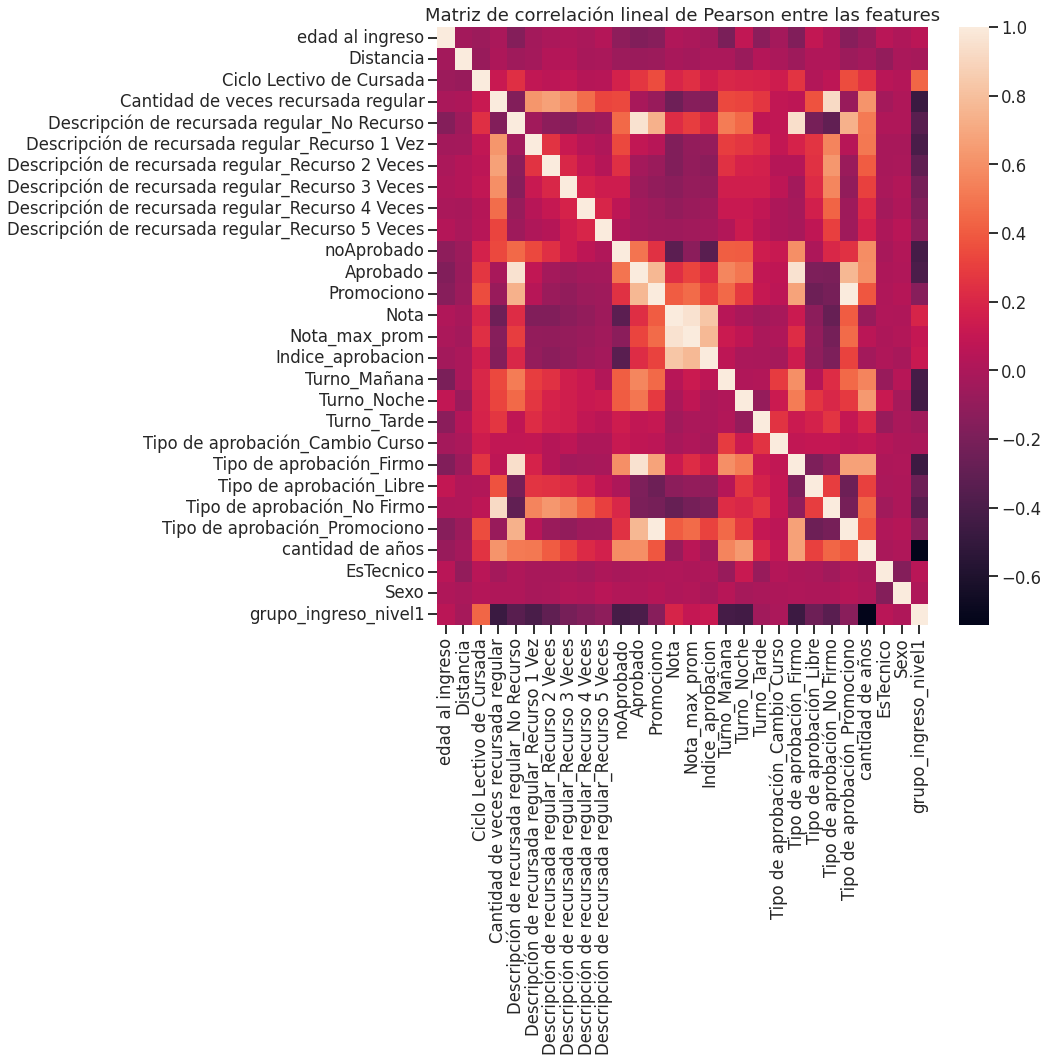

In [167]:
## Elaboramos e imprimimos la matriz de correlación lineal de Pearson entre las features.
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
plt.subplots(figsize=(11, 11))
sns.heatmap(np.corrcoef(normalize_xtrain_over.T), xticklabels=normalize_xtrain_over.columns, yticklabels=normalize_xtrain_over.columns)
plt.title('Matriz de correlación lineal de Pearson entre las features')
plt.show()

In [168]:
normalize_train_over = pd.concat([normalize_xtrain_over,pd.DataFrame(ytrain_over)], axis=1)

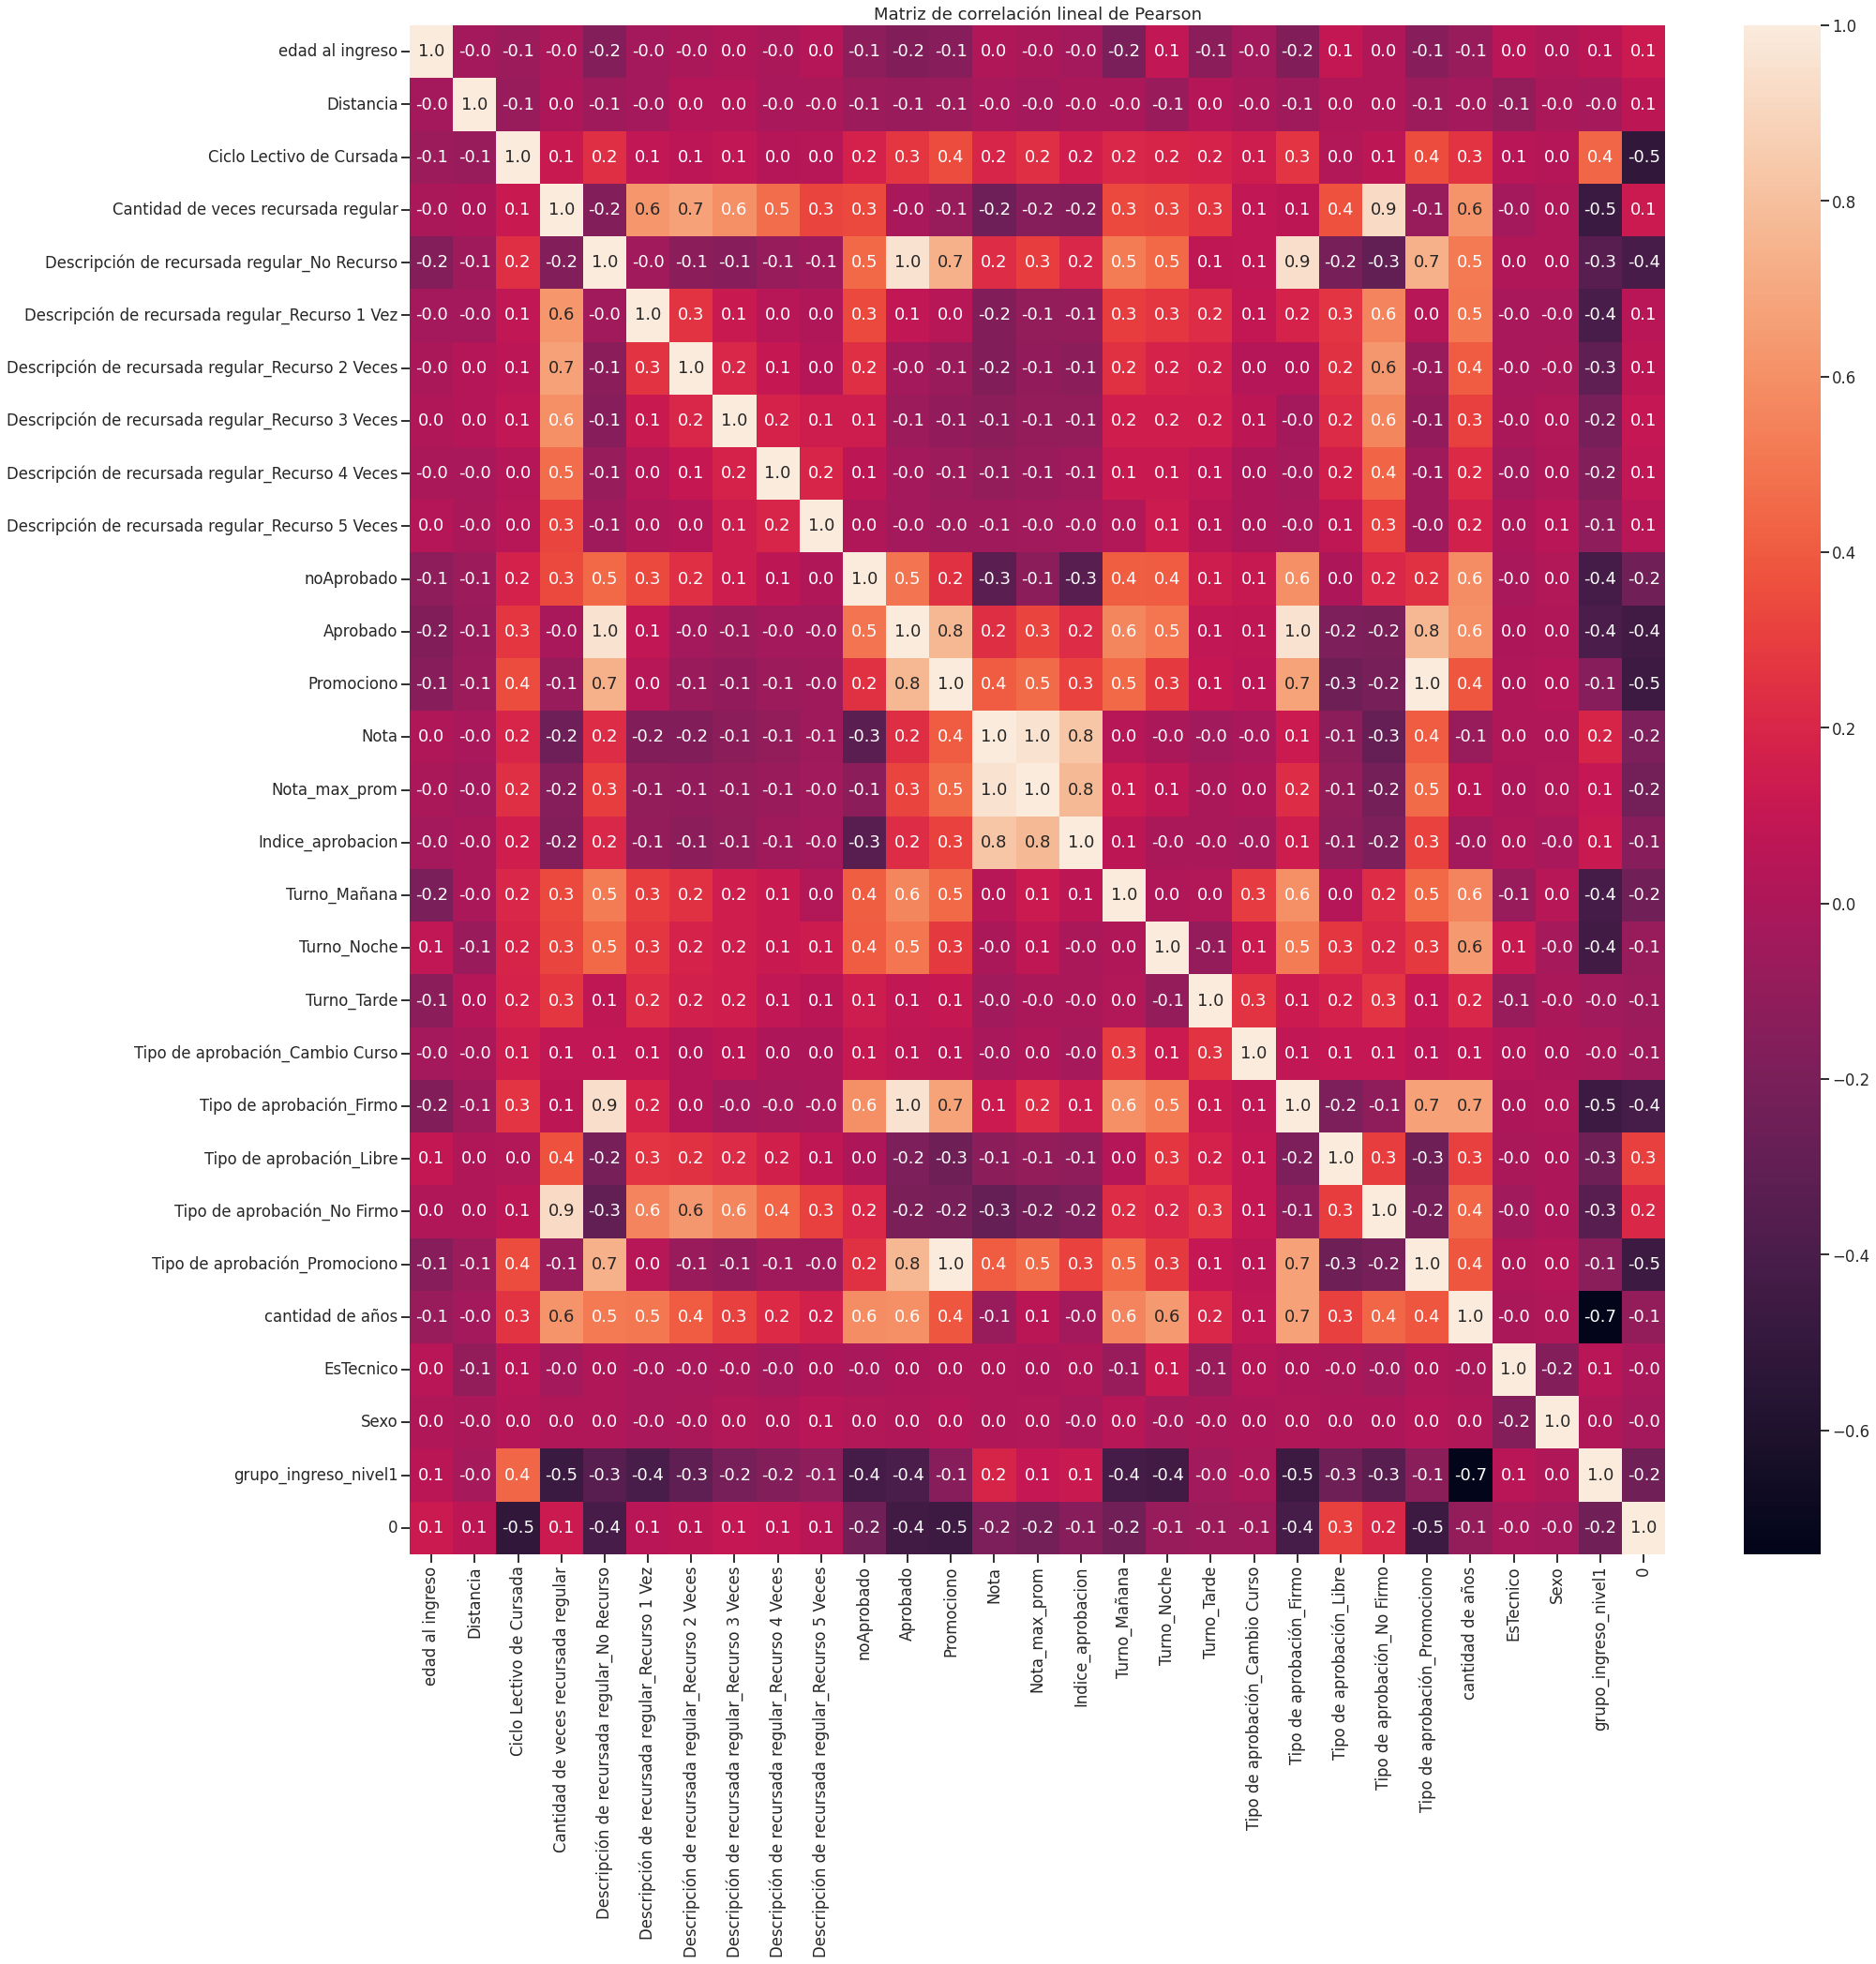

In [169]:
## Elaboramos e imprimimos la matriz de correlación lineal de Pearson entre las features y la variable a predecir.
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
plt.subplots(figsize=(30, 30))
sns.heatmap(np.corrcoef(normalize_train_over.T), xticklabels=normalize_train_over.columns, yticklabels=normalize_train_over.columns, annot = True, fmt = '.1f')
plt.title('Matriz de correlación lineal de Pearson')
plt.show()

##**Pipeline de Machine Learning**

In [170]:
## Creamos un Pipeline para aplicar secuencialmente la lista de transformaciones definida previamente y un estimador final.
pipeline1 = Pipeline(
    steps=[("preprocesamiento",preprocesamiento),("estimador",SVC(probability=True))]
)

In [179]:
## Definimos los hiperparámetros de los modelos a comparar.
parametros = [
    {    
        "estimador": (LogisticRegression(),),
          "estimador__C": (0.001, 1, 10, 100, 1000)
    },
     {
        "estimador": (SVC(probability=True),),
          "estimador__kernel":('rbf',), 
          "estimador__C":(0.1, 1, 10, 100, 1000), 
          "estimador__gamma":(0.01, 0.001, 0.0001)      
    }
]

In [180]:
## Creamos el Grid Search + Cross Validation.
grid_search1 = GridSearchCV(pipeline1, parametros,
                  refit = True,
                   cv = 5, ## Folds
                   verbose=40)

In [181]:
## Implementamos el GSCV con el set de train.
grid_search1.fit(xtrain_over,ytrain_over.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START estimador=LogisticRegression(), estimador__C=0.001.........
[CV 1/5; 1/20] END estimador=LogisticRegression(), estimador__C=0.001;, score=0.826 total time=   0.1s
[CV 2/5; 1/20] START estimador=LogisticRegression(), estimador__C=0.001.........
[CV 2/5; 1/20] END estimador=LogisticRegression(), estimador__C=0.001;, score=0.810 total time=   0.0s
[CV 3/5; 1/20] START estimador=LogisticRegression(), estimador__C=0.001.........
[CV 3/5; 1/20] END estimador=LogisticRegression(), estimador__C=0.001;, score=0.809 total time=   0.0s
[CV 4/5; 1/20] START estimador=LogisticRegression(), estimador__C=0.001.........
[CV 4/5; 1/20] END estimador=LogisticRegression(), estimador__C=0.001;, score=0.803 total time=   0.0s
[CV 5/5; 1/20] START estimador=LogisticRegression(), estimador__C=0.001.........
[CV 5/5; 1/20] END estimador=LogisticRegression(), estimador__C=0.001;, score=0.824 total time=   0.1s
[CV 1/5; 2/20] STA

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 2/5; 2/20] END estimador=LogisticRegression(), estimador__C=1;, score=0.836 total time=   0.1s
[CV 3/5; 2/20] START estimador=LogisticRegression(), estimador__C=1.............
[CV 3/5; 2/20] END estimador=LogisticRegression(), estimador__C=1;, score=0.831 total time=   0.1s
[CV 4/5; 2/20] START estimador=LogisticRegression(), estimador__C=1.............
[CV 4/5; 2/20] END estimador=LogisticRegression(), estimador__C=1;, score=0.847 total time=   0.1s
[CV 5/5; 2/20] START estimador=LogisticRegression(), estimador__C=1.............


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5; 2/20] END estimador=LogisticRegression(), estimador__C=1;, score=0.855 total time=   0.1s
[CV 1/5; 3/20] START estimador=LogisticRegression(), estimador__C=10............
[CV 1/5; 3/20] END estimador=LogisticRegression(), estimador__C=10;, score=0.852 total time=   0.1s
[CV 2/5; 3/20] START estimador=LogisticRegression(), estimador__C=10............
[CV 2/5; 3/20] END estimador=LogisticRegression(), estimador__C=10;, score=0.836 total time=   0.1s
[CV 3/5; 3/20] START estimador=LogisticRegression(), estimador__C=10............


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 3/5; 3/20] END estimador=LogisticRegression(), estimador__C=10;, score=0.839 total time=   0.1s
[CV 4/5; 3/20] START estimador=LogisticRegression(), estimador__C=10............
[CV 4/5; 3/20] END estimador=LogisticRegression(), estimador__C=10;, score=0.845 total time=   0.1s
[CV 5/5; 3/20] START estimador=LogisticRegression(), estimador__C=10............


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5; 3/20] END estimador=LogisticRegression(), estimador__C=10;, score=0.847 total time=   0.2s
[CV 1/5; 4/20] START estimador=LogisticRegression(), estimador__C=100...........
[CV 1/5; 4/20] END estimador=LogisticRegression(), estimador__C=100;, score=0.849 total time=   0.1s
[CV 2/5; 4/20] START estimador=LogisticRegression(), estimador__C=100...........


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 2/5; 4/20] END estimador=LogisticRegression(), estimador__C=100;, score=0.831 total time=   0.1s
[CV 3/5; 4/20] START estimador=LogisticRegression(), estimador__C=100...........
[CV 3/5; 4/20] END estimador=LogisticRegression(), estimador__C=100;, score=0.836 total time=   0.1s
[CV 4/5; 4/20] START estimador=LogisticRegression(), estimador__C=100...........


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 4/5; 4/20] END estimador=LogisticRegression(), estimador__C=100;, score=0.844 total time=   0.1s
[CV 5/5; 4/20] START estimador=LogisticRegression(), estimador__C=100...........
[CV 5/5; 4/20] END estimador=LogisticRegression(), estimador__C=100;, score=0.857 total time=   0.1s
[CV 1/5; 5/20] START estimador=LogisticRegression(), estimador__C=1000..........


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 1/5; 5/20] END estimador=LogisticRegression(), estimador__C=1000;, score=0.839 total time=   0.1s
[CV 2/5; 5/20] START estimador=LogisticRegression(), estimador__C=1000..........
[CV 2/5; 5/20] END estimador=LogisticRegression(), estimador__C=1000;, score=0.836 total time=   0.1s
[CV 3/5; 5/20] START estimador=LogisticRegression(), estimador__C=1000..........


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 3/5; 5/20] END estimador=LogisticRegression(), estimador__C=1000;, score=0.829 total time=   0.1s
[CV 4/5; 5/20] START estimador=LogisticRegression(), estimador__C=1000..........
[CV 4/5; 5/20] END estimador=LogisticRegression(), estimador__C=1000;, score=0.858 total time=   0.1s
[CV 5/5; 5/20] START estimador=LogisticRegression(), estimador__C=1000..........


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5; 5/20] END estimador=LogisticRegression(), estimador__C=1000;, score=0.855 total time=   0.2s
[CV 1/5; 6/20] START estimador=SVC(probability=True), estimador__C=0.1, estimador__gamma=0.01, estimador__kernel=rbf
[CV 1/5; 6/20] END estimador=SVC(probability=True), estimador__C=0.1, estimador__gamma=0.01, estimador__kernel=rbf;, score=0.798 total time=   1.9s
[CV 2/5; 6/20] START estimador=SVC(probability=True), estimador__C=0.1, estimador__gamma=0.01, estimador__kernel=rbf
[CV 2/5; 6/20] END estimador=SVC(probability=True), estimador__C=0.1, estimador__gamma=0.01, estimador__kernel=rbf;, score=0.789 total time=   1.2s
[CV 3/5; 6/20] START estimador=SVC(probability=True), estimador__C=0.1, estimador__gamma=0.01, estimador__kernel=rbf
[CV 3/5; 6/20] END estimador=SVC(probability=True), estimador__C=0.1, estimador__gamma=0.01, estimador__kernel=rbf;, score=0.798 total time=   1.3s
[CV 4/5; 6/20] START estimador=SVC(probability=True), estimador__C=0.1, estimador__gamma=0.01, estimado

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['edad '
                                                                          'al '
                                                                          'ingreso',
                                                                          'Distancia',
                                                                          'Ciclo '
                                                                          'Lectivo '
                                                                          'de '
                                                

In [182]:
## Guardamos en una variable toda la informacion del entrenamiento que quedó registrada en 'cv_results_'.
scores = grid_search1.cv_results_

## Imprimimos la informacion del entrenamiento.
scores_df = pd.DataFrame.from_dict(scores)
scores_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimador,param_estimador__C,param_estimador__gamma,param_estimador__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.044665,0.007780,0.004682,0.000717,LogisticRegression(),0.001,NaN,NaN,"{'estimador': LogisticRegression(), 'estimador...",0.826016,0.809756,0.809446,0.802932,0.824104,0.814451,0.009019,15
1,0.064172,0.011128,0.006586,0.002233,LogisticRegression(),1,NaN,NaN,"{'estimador': LogisticRegression(), 'estimador...",0.858537,0.835772,0.830619,0.846906,0.855049,0.845376,0.010762,7
2,0.094611,0.030110,0.006497,0.002832,LogisticRegression(),10,NaN,NaN,"{'estimador': LogisticRegression(), 'estimador...",0.852033,0.835772,0.838762,0.845277,0.846906,0.843750,0.005821,8
3,0.120149,0.008018,0.009349,0.001977,LogisticRegression(),100,NaN,NaN,"{'estimador': LogisticRegression(), 'estimador...",0.848780,0.830894,0.835505,0.843648,0.856678,0.843101,0.009204,10
4,0.126834,0.011055,0.007719,0.001589,LogisticRegression(),1000,NaN,NaN,"{'estimador': LogisticRegression(), 'estimador...",0.839024,0.835772,0.828990,0.858306,0.855049,0.843428,0.011339,9


In [214]:
## Imprimimos cual fue la mejor combinación de hiperparámetros.
print("Con un score de %0.4f, la mejor combinación de hiperparámtros fue: \n %s" % (grid_search1.best_score_, grid_search1.best_params_))

Con un score de 0.8698, la mejor combinación de hiperparámtros fue: 
 {'estimador': SVC(C=1000, gamma=0.01, probability=True), 'estimador__C': 1000, 'estimador__gamma': 0.001, 'estimador__kernel': 'rbf'}


In [215]:
## Obtenemos las predicciones a partir del modelo entrenado.
ypred = grid_search1.predict(xtest)

##**Mediciones de desempeño**##

In [216]:
## Calculamos el accuracy.
test_acc = accuracy_score(ytest, ypred)
print("El accuracy es " + str(test_acc))

El accuracy es 0.8311499272197962


In [217]:
## Computamos el área abajo de la curva ROC.
yproba = grid_search1.predict_proba(xtest)
fpr, tpr, thresholds = roc_curve(ytest.astype(int), yproba[:,1], drop_intermediate = False, pos_label=1)
auc_value = auc(fpr, tpr)
print("El AUC es = " + str(auc_value))

El AUC es = 0.9092957489509215


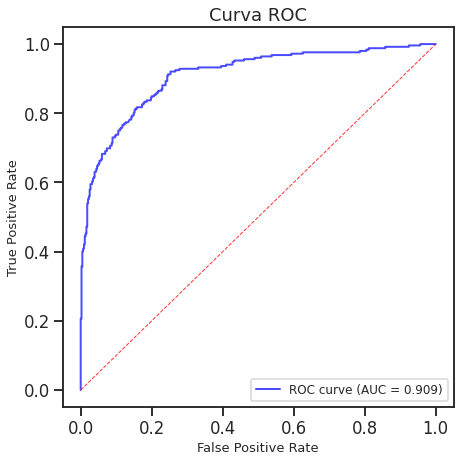

In [218]:
## Imprimimos la curva ROC.
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, lw=2, alpha=0.7 , label="ROC curve (AUC = %0.3f)" % auc_value, color = 'b')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', alpha=.8)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(False)
plt.legend(loc="lower right",fontsize=12)
plt.title('Curva ROC',fontsize=18)
plt.show()

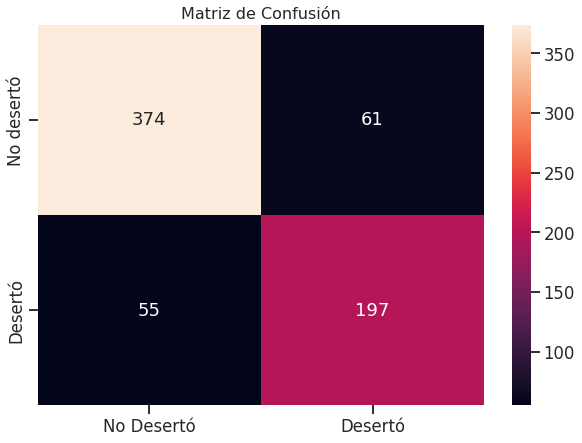

In [219]:
## Calculamos e imprimimos la Matriz de Confusión.
cm = confusion_matrix(ytest, ypred)
df_cm = pd.DataFrame(cm, index = ['No desertó', 'Desertó'], columns = ['No Desertó', "Desertó"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt='g')
plt.title('Matriz de Confusión', fontsize=16)
plt.show()


##**Analisis de Componentes Pricipales**

In [189]:
## Fijamos el porcentaje de varianza que deberán explicar los autovectores que se seleccionarán. 
n_comps = 0.8

## Definimos el PCA.
pca = PCA(n_components= n_comps)

In [190]:
## Definimos las transformaciones a realizar para las variables numéricas. 
## Las estandarizaremos utilizando StandardScaler y luego aplicamos el método PCA.
numeric_transformer2 = Pipeline(
    steps=[("scaler", StandardScaler()), ("pca", pca)]
)

## Juntamos las transformaciones definidas previamente.
## Definimos el ColumnTransformer que será ejecutado al momento del fitting.
preprocesamiento2 = ColumnTransformer(
    transformers=[ 
        ("num", numeric_transformer2, num_features),
        ("cat", do_nothing, cat_features)
    ]
)

## Definimos un nuevo pipeline que incluye el método PCA en el preprosemiento.
pipeline2=Pipeline(
    steps=[('preprocesamiento',preprocesamiento2),('estimador',SVC())]
)

In [191]:
## Observamos como queda el dataset que se obtine a partir de la reducción de la dimensionalidad.
pd.DataFrame(preprocesamiento2.fit_transform(xtrain_over))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-3.892910,0.132435,-3.828262,1.069803,0.049959,1.476552,-0.714340,-0.070941,1.442107,-0.538341,1.0,0.0,140.0
1,-0.883091,-1.860747,0.477620,-0.129868,-0.443817,0.835758,-0.497302,-0.609766,0.070559,-0.260044,1.0,1.0,113.0
2,-0.650113,0.022264,-1.468452,-1.531997,-0.637468,1.198565,-0.383123,1.648745,-0.423627,0.105894,0.0,0.0,83.0
3,5.184833,-2.389342,-1.232172,-0.041060,0.223771,0.067914,2.349273,-1.748747,-0.053212,0.096495,0.0,0.0,20.0
4,-1.991912,-0.860493,-1.276326,-0.423419,0.422282,-0.386764,0.480722,-0.523841,-0.756043,0.201731,0.0,0.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,-0.739199,1.777325,-2.064874,1.764669,-0.215991,-1.090293,-0.214197,0.474486,-0.158453,-0.254126,0.0,0.0,0.0
3068,-1.192120,-0.249151,-0.548714,1.810581,-1.365364,0.637106,0.067016,-0.215914,-0.859225,-0.692963,1.0,0.0,77.0
3069,0.312746,3.491059,0.164406,2.729230,-1.377566,-0.094133,-0.246034,-0.316209,0.673273,-1.550294,1.0,0.0,47.0
3070,3.219794,2.642457,0.201403,2.035579,1.020720,-0.165310,-0.646169,-0.376734,-0.771522,-0.895443,1.0,0.0,30.0


In [192]:
## Creamos el nuevo GSCV.
grid_search2 = GridSearchCV(pipeline2, parametros,
                  refit = True, 
                   cv = 5,
                   verbose=40)

In [193]:
## Implementamos el GSCV.
grid_search2.fit(xtrain_over,ytrain_over.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START estimador=LogisticRegression(), estimador__C=0.001.........
[CV 1/5; 1/20] END estimador=LogisticRegression(), estimador__C=0.001;, score=0.811 total time=   0.1s
[CV 2/5; 1/20] START estimador=LogisticRegression(), estimador__C=0.001.........
[CV 2/5; 1/20] END estimador=LogisticRegression(), estimador__C=0.001;, score=0.805 total time=   0.1s
[CV 3/5; 1/20] START estimador=LogisticRegression(), estimador__C=0.001.........
[CV 3/5; 1/20] END estimador=LogisticRegression(), estimador__C=0.001;, score=0.811 total time=   0.0s
[CV 4/5; 1/20] START estimador=LogisticRegression(), estimador__C=0.001.........
[CV 4/5; 1/20] END estimador=LogisticRegression(), estimador__C=0.001;, score=0.808 total time=   0.1s
[CV 5/5; 1/20] START estimador=LogisticRegression(), estimador__C=0.001.........
[CV 5/5; 1/20] END estimador=LogisticRegression(), estimador__C=0.001;, score=0.818 total time=   0.0s
[CV 1/5; 2/20] STA

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 2/5; 2/20] END estimador=LogisticRegression(), estimador__C=1;, score=0.815 total time=   0.1s
[CV 3/5; 2/20] START estimador=LogisticRegression(), estimador__C=1.............
[CV 3/5; 2/20] END estimador=LogisticRegression(), estimador__C=1;, score=0.814 total time=   0.1s
[CV 4/5; 2/20] START estimador=LogisticRegression(), estimador__C=1.............


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 4/5; 2/20] END estimador=LogisticRegression(), estimador__C=1;, score=0.816 total time=   0.1s
[CV 5/5; 2/20] START estimador=LogisticRegression(), estimador__C=1.............
[CV 5/5; 2/20] END estimador=LogisticRegression(), estimador__C=1;, score=0.829 total time=   0.1s
[CV 1/5; 3/20] START estimador=LogisticRegression(), estimador__C=10............


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 1/5; 3/20] END estimador=LogisticRegression(), estimador__C=10;, score=0.831 total time=   0.1s
[CV 2/5; 3/20] START estimador=LogisticRegression(), estimador__C=10............
[CV 2/5; 3/20] END estimador=LogisticRegression(), estimador__C=10;, score=0.816 total time=   0.1s
[CV 3/5; 3/20] START estimador=LogisticRegression(), estimador__C=10............
[CV 3/5; 3/20] END estimador=LogisticRegression(), estimador__C=10;, score=0.809 total time=   0.1s
[CV 4/5; 3/20] START estimador=LogisticRegression(), estimador__C=10............


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 4/5; 3/20] END estimador=LogisticRegression(), estimador__C=10;, score=0.816 total time=   0.1s
[CV 5/5; 3/20] START estimador=LogisticRegression(), estimador__C=10............
[CV 5/5; 3/20] END estimador=LogisticRegression(), estimador__C=10;, score=0.831 total time=   0.1s
[CV 1/5; 4/20] START estimador=LogisticRegression(), estimador__C=100...........


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 1/5; 4/20] END estimador=LogisticRegression(), estimador__C=100;, score=0.833 total time=   0.1s
[CV 2/5; 4/20] START estimador=LogisticRegression(), estimador__C=100...........
[CV 2/5; 4/20] END estimador=LogisticRegression(), estimador__C=100;, score=0.815 total time=   0.1s
[CV 3/5; 4/20] START estimador=LogisticRegression(), estimador__C=100...........
[CV 3/5; 4/20] END estimador=LogisticRegression(), estimador__C=100;, score=0.809 total time=   0.1s
[CV 4/5; 4/20] START estimador=LogisticRegression(), estimador__C=100...........
[CV 4/5; 4/20] END estimador=LogisticRegression(), estimador__C=100;, score=0.824 total time=   0.1s
[CV 5/5; 4/20] START estimador=LogisticRegression(), estimador__C=100...........


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5; 4/20] END estimador=LogisticRegression(), estimador__C=100;, score=0.832 total time=   0.1s
[CV 1/5; 5/20] START estimador=LogisticRegression(), estimador__C=1000..........
[CV 1/5; 5/20] END estimador=LogisticRegression(), estimador__C=1000;, score=0.834 total time=   0.1s
[CV 2/5; 5/20] START estimador=LogisticRegression(), estimador__C=1000..........
[CV 2/5; 5/20] END estimador=LogisticRegression(), estimador__C=1000;, score=0.815 total time=   0.1s
[CV 3/5; 5/20] START estimador=LogisticRegression(), estimador__C=1000..........
[CV 3/5; 5/20] END estimador=LogisticRegression(), estimador__C=1000;, score=0.811 total time=   0.1s
[CV 4/5; 5/20] START estimador=LogisticRegression(), estimador__C=1000..........


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 4/5; 5/20] END estimador=LogisticRegression(), estimador__C=1000;, score=0.814 total time=   0.1s
[CV 5/5; 5/20] START estimador=LogisticRegression(), estimador__C=1000..........
[CV 5/5; 5/20] END estimador=LogisticRegression(), estimador__C=1000;, score=0.831 total time=   0.1s
[CV 1/5; 6/20] START estimador=SVC(C=1000, gamma=0.001, probability=True), estimador__C=0.1, estimador__gamma=0.01, estimador__kernel=rbf


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 6/20] END estimador=SVC(C=1000, gamma=0.001, probability=True), estimador__C=0.1, estimador__gamma=0.01, estimador__kernel=rbf;, score=0.798 total time=   1.1s
[CV 2/5; 6/20] START estimador=SVC(C=1000, gamma=0.001, probability=True), estimador__C=0.1, estimador__gamma=0.01, estimador__kernel=rbf
[CV 2/5; 6/20] END estimador=SVC(C=1000, gamma=0.001, probability=True), estimador__C=0.1, estimador__gamma=0.01, estimador__kernel=rbf;, score=0.787 total time=   1.1s
[CV 3/5; 6/20] START estimador=SVC(C=1000, gamma=0.001, probability=True), estimador__C=0.1, estimador__gamma=0.01, estimador__kernel=rbf
[CV 3/5; 6/20] END estimador=SVC(C=1000, gamma=0.001, probability=True), estimador__C=0.1, estimador__gamma=0.01, estimador__kernel=rbf;, score=0.800 total time=   1.9s
[CV 4/5; 6/20] START estimador=SVC(C=1000, gamma=0.001, probability=True), estimador__C=0.1, estimador__gamma=0.01, estimador__kernel=rbf
[CV 4/5; 6/20] END estimador=SVC(C=1000, gamma=0.001, probability=True), estima

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA(n_components=0.8))]),
                                                                         ['edad '
                                                                          'al '
                                                                          'ingreso',
                                                                          'Distancia',
                                                                          'Ciclo '
  

In [220]:
## Guardamos en una variable toda la informacion del entrenamiento que quedó registrada en 'cv_results_'.
scores2 = grid_search2.cv_results_

## Imprimimos la informacion del entrenamiento.
scores2_df = pd.DataFrame.from_dict(scores)
scores2_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimador,param_estimador__C,param_estimador__gamma,param_estimador__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.044665,0.007780,0.004682,0.000717,LogisticRegression(),0.001,NaN,NaN,"{'estimador': LogisticRegression(), 'estimador...",0.826016,0.809756,0.809446,0.802932,0.824104,0.814451,0.009019,15
1,0.064172,0.011128,0.006586,0.002233,LogisticRegression(),1,NaN,NaN,"{'estimador': LogisticRegression(), 'estimador...",0.858537,0.835772,0.830619,0.846906,0.855049,0.845376,0.010762,7
2,0.094611,0.030110,0.006497,0.002832,LogisticRegression(),10,NaN,NaN,"{'estimador': LogisticRegression(), 'estimador...",0.852033,0.835772,0.838762,0.845277,0.846906,0.843750,0.005821,8
3,0.120149,0.008018,0.009349,0.001977,LogisticRegression(),100,NaN,NaN,"{'estimador': LogisticRegression(), 'estimador...",0.848780,0.830894,0.835505,0.843648,0.856678,0.843101,0.009204,10
4,0.126834,0.011055,0.007719,0.001589,LogisticRegression(),1000,NaN,NaN,"{'estimador': LogisticRegression(), 'estimador...",0.839024,0.835772,0.828990,0.858306,0.855049,0.843428,0.011339,9


In [221]:
## Imprimimos cual fue el mejor modelo (estimator) y combinación de hiperparámetros.
print("Con un score de %0.4f, la mejor combinación de hiperparámtros fue: \n %s" % (grid_search2.best_score_, grid_search2.best_params_))

Con un score de 0.8464, la mejor combinación de hiperparámtros fue: 
 {'estimador': SVC(C=1000, gamma=0.01, probability=True), 'estimador__C': 1000, 'estimador__gamma': 0.01, 'estimador__kernel': 'rbf'}


In [222]:
## Obtenemos las predicciones a partir del modelo entrenado.
ypred2 = grid_search2.predict(xtest)

In [223]:
## Calculamos el accuracy.
test_acc2 = accuracy_score(ytest, ypred2)
print("El accuracy es " + str(test_acc2))

El accuracy es 0.7976710334788938


In [225]:
## Computamos el área abajo de la curva ROC.
yproba2 = grid_search2.predict_proba(xtest)
fpr2, tpr2, thresholds = roc_curve(ytest.astype(int), yproba2[:,1], drop_intermediate = False, pos_label=1)
auc_value2 = auc(fpr2, tpr2)
print("El AUC es = " + str(auc_value2))

El AUC es = 0.8518016785258165


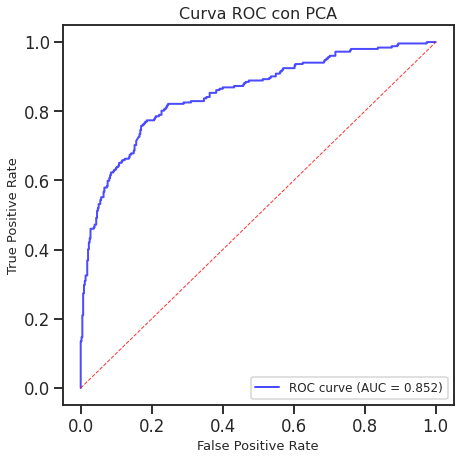

In [226]:
## Imprimimos la curva ROC.
plt.figure(figsize=(7,7))
plt.plot(fpr2, tpr2, lw=2, alpha=0.7 , label="ROC curve (AUC = %0.3f)" % auc_value2, color = 'b')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', alpha=.8)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(False)
plt.legend(loc="lower right", fontsize=12)
plt.title('Curva ROC con PCA', fontsize=16)
plt.show()

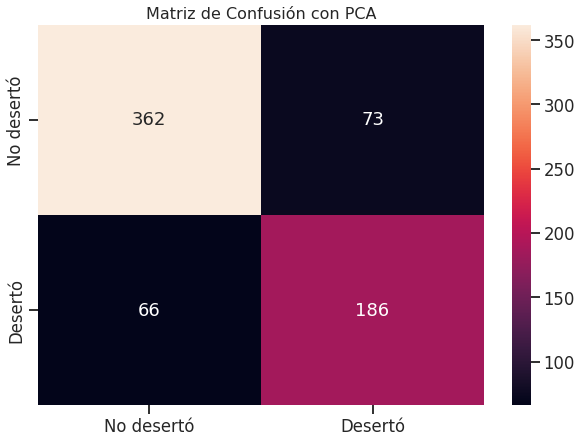

In [227]:
## Calculamos e imprimimos la Matriz de Confusión.
cm2 = confusion_matrix(ytest, ypred2)
df_cm2 = pd.DataFrame(cm2, index = ['No desertó', 'Desertó'], columns = ['No desertó', "Desertó"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm2, annot=True,fmt='g')
plt.title('Matriz de Confusión con PCA', fontsize=16)
plt.show()